In [1]:
# Author: Eric Chandler <echandler@uchicago.edu>
# Description: Trying to write some computer code to make sense of the Durlauf-Seshadri paper

## Goals
Implement the Durlauf-Seshadri model as a simulation, reproduce the expected stylized facts, identify causal mechanism, test implications of extending model or relaxing certain assumptions.
## 
The paper's main arguments are 1) segregation causes and aggravates inequality 2) and that inequality decreases subsequent generations' mobility.
## Stylized Facts
* intertemporal great gadby curve emerges
* permanent segregation without explicit poverty/affluence traps
## Model Structure
* income is certain and depends on child human capital
* only two periods of life (child/get capital, adult/get income)
* local public finance of schools
* students in same school gain same amount of capital from school
* parents prefer more affluent, larger neighborhoods
* inequality increases segregation

## Key Assumptions
* local public finance of schools
* no marriage or inter-family income sharing
* one child, no elders, no population growth or shrink
* no direct parental investment (only via neighborhood)
* parental utility depends on child expected income, not on child expected utility or human capital
* no credit constraint
## Further Directions
* alternative mechanisms for mobility:
    * credit constraints
    * productivity of parent capital investment in child depends on parent capital level
    * other ways for heterogenous AR
* peer effects in capital development
* role model effects in capital development
* alternative utility functions:
    * child expected utility (implicitly includes dynasty income after t+1)
    * child human capital
* heterogeneous preferences in utility function: what general conditions allow equilibriums?




## Model
cross-sectional inequality -> neighborhood differences

segregation:= increasing function of cross-sectional inequality

mobility := parental input + neighborhood quality

agents in firm/school split earninge evenly. no additional benefits for most productive person.

### Optional
* assortive matching of workers by skill because its more efficient overall
* assortive matching of students to schools because its more efficient overall
* spatial segregation




In [8]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sim import Sim

## Define Model Processes

/Users/eric/Documents/Workshops Talks OneOffs/Intergenerational Mobility/sim.py:194: RuntimeWarning: invalid value encountered in true_divide
  total_income = positive_income.sum(axis=1)
CPU times: user 840 ms, sys: 10.9 ms, total: 851 ms
Wall time: 851 ms


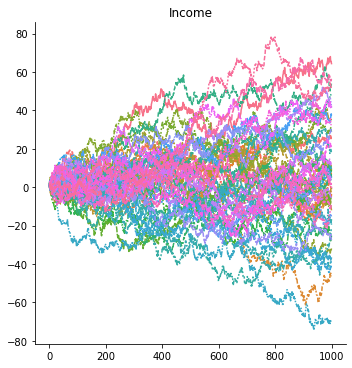

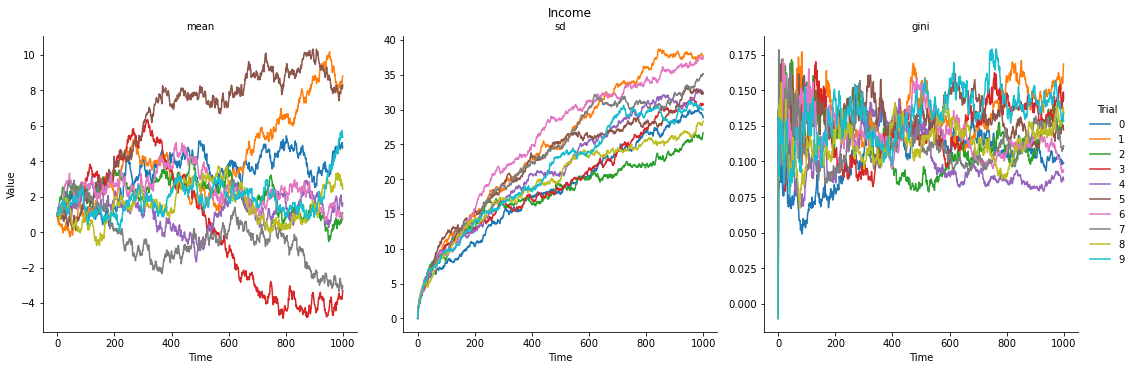

In [31]:
sim = Sim()
sim.set('INCOME_MOBILITY_COEF',1)
sim.set('INCOME_NOISE_AUTOREG',0)
sim.set('TAX_RATE', 0)
sim.set('N_TIMESTEPS',1000)
%time res = sim.run(10, keep_trials=True)
res.income.trial_data[0].plot()
res.income.plot()

CPU times: user 253 ms, sys: 2.65 ms, total: 256 ms
Wall time: 255 ms


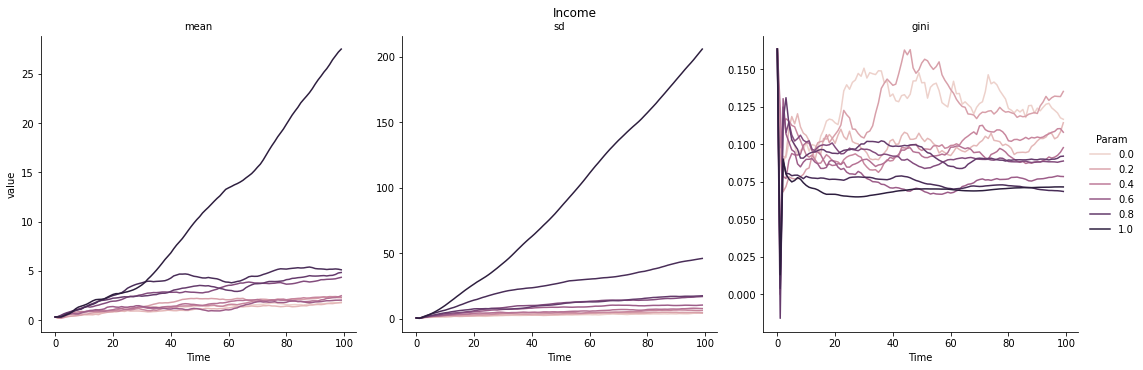

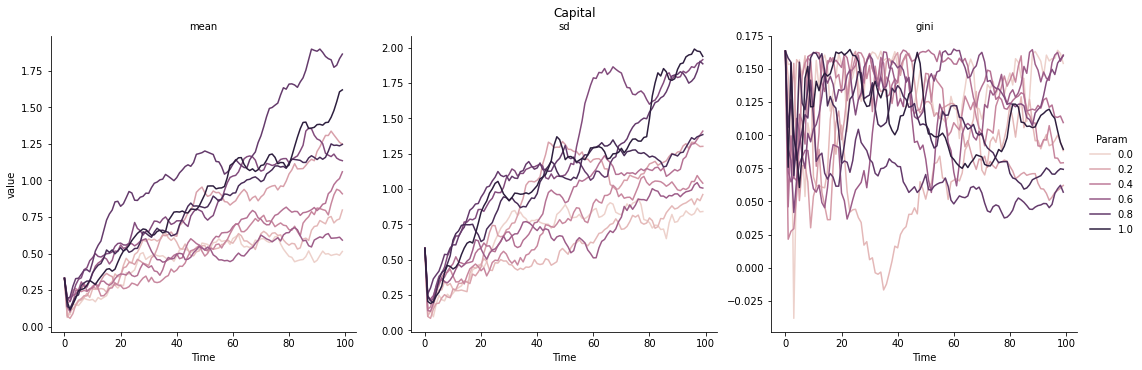

In [29]:
sim = Sim()
%time res = sim.run_sweep('INCOME_MOBILITY_COEF', np.linspace(0,1,10), ntrials=1)
res.income.plot()
res.human_capital.plot()